# Use CNN to detect breast cancer 

In [1]:
# General packages
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import random

from matplotlib.image import imread
import cv2

# Packages for ML
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D


In [2]:
fd = 'archive/IDC_regular_ps50_idx5'

imagePatches = glob(fd + '/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [3]:
len(imagePatches)

277524

In [4]:
# bin the data to cancer and no cancer

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

display('Size of the class 0 = ',len(class0))
display('Size of the class 1 = ',len(class1))

'Size of the class 0 = '

198738

'Size of the class 1 = '

78786

In [19]:
# randomly select 1000 images from each class

num_sample_selected = 10000
rand_sample_class0 = random.sample(class0, num_sample_selected)
rand_sample_class1 = random.sample(class1, num_sample_selected)


In [20]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = imread(i )
            img_sized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [21]:
class0_array = get_image_arrays(rand_sample_class0, 0)
class1_array = get_image_arrays(rand_sample_class1, 1)

In [22]:
len(class0_array)

10000

(50, 50, 3)

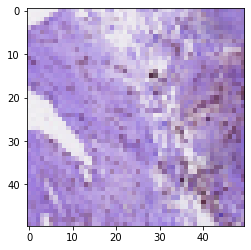

In [23]:
test = cv2.imread(fd + '/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
plt.imshow(test)

display(test.shape)

In [24]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(10)
random.shuffle(combined_data)

In [25]:
combined_data.shape

(20000, 2)

In [26]:
X = []
y = []

for i in range(combined_data.shape[0]):
    X.append(combined_data[i][0])
    y.append(combined_data[i][1])



In [27]:
X = np.array(X).reshape(-1, 64, 64, 3)

In [28]:
print(torch.cuda.is_available())

False


In [29]:
X.shape

(20000, 64, 64, 3)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15000, 64, 64, 3) (5000, 64, 64, 3) (15000, 2) (5000, 2)


In [31]:
def create_model():        
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu'))
    #model.add(Conv2D(filters = 16, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

In [32]:
model = create_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 30,
    verbose = 2,
)

Epoch 1/30
469/469 - 60s - loss: 0.3613 - accuracy: 0.8485 - val_loss: 0.3480 - val_accuracy: 0.8480 - 60s/epoch - 129ms/step
Epoch 2/30
469/469 - 57s - loss: 0.3337 - accuracy: 0.8600 - val_loss: 0.3319 - val_accuracy: 0.8654 - 57s/epoch - 121ms/step
Epoch 3/30
469/469 - 60s - loss: 0.3250 - accuracy: 0.8702 - val_loss: 0.3397 - val_accuracy: 0.8728 - 60s/epoch - 128ms/step
Epoch 4/30
469/469 - 63s - loss: 0.3178 - accuracy: 0.8743 - val_loss: 0.3463 - val_accuracy: 0.8722 - 63s/epoch - 134ms/step
Epoch 5/30
469/469 - 55s - loss: 0.3098 - accuracy: 0.8791 - val_loss: 0.3052 - val_accuracy: 0.8782 - 55s/epoch - 117ms/step
Epoch 6/30
469/469 - 49s - loss: 0.2904 - accuracy: 0.8870 - val_loss: 0.3115 - val_accuracy: 0.8802 - 49s/epoch - 105ms/step
Epoch 7/30
469/469 - 52s - loss: 0.2825 - accuracy: 0.8939 - val_loss: 0.3092 - val_accuracy: 0.8820 - 52s/epoch - 111ms/step
Epoch 8/30
469/469 - 57s - loss: 0.2703 - accuracy: 0.8966 - val_loss: 0.2927 - val_accuracy: 0.8884 - 57s/epoch - 122

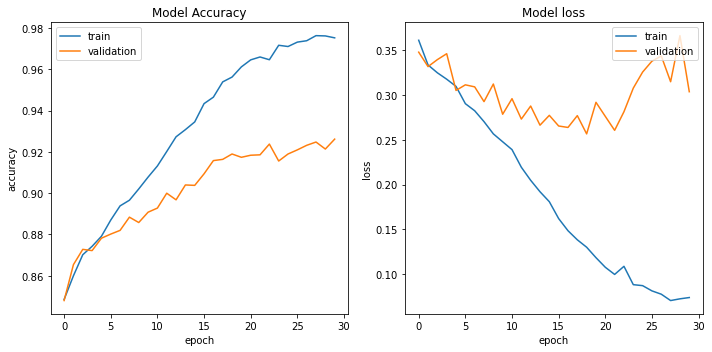

In [35]:
fig, axs = plt.subplots(1,3,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

fig.tight_layout()
plt.savefig('Simple_CNN_v3.png',dpi=300)
plt.show()

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])